In [53]:
import glob, random, time, os, sys

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.cluster import KMeans, DBSCAN, OPTICS, HDBSCAN, MiniBatchKMeans

In [54]:
files = glob.glob(os.path.join('/Users/haoyu/Documents/datasets/lpr/mini_train', '*.jpg'))
# files = glob.glob(os.path.join('debug', '*.jpg'))
random.shuffle(files)
path = files[0]

In [55]:
# resize and keep the aspect ratio
def resize(image, width=None, height=None):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    resized = cv2.resize(image, dim)
    # return the resized image
    return resized

# minBatchKmeans
def minBatchKmeans(image, k=2):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel_values = np.float32(image.reshape(-1))
    kmeans = MiniBatchKMeans(
        init='k-means++',
        max_iter=20,
        n_clusters=k,
        random_state=0,
    ).fit(pixel_values.reshape(-1, 1))
    segmented_image = kmeans.labels_.reshape(image.shape)
    return segmented_image


def kmeans(image, k=2):
    if len(image.shape) == 2:
        Z = image.reshape((-1, 1))
    else:
        Z = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Z = Z.reshape((-1, 1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape[0], image.shape[1], 1))
    return res2

In [56]:
image_raw = cv2.imread(path)
image_raw = resize(image_raw, width=256)
image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 31))
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(11, 3))
image = clahe.apply(image)
# denoise
image = cv2.fastNlMeansDenoising(image, None, 10, 11, 27)

# image = cv2.equalizeHist(image)

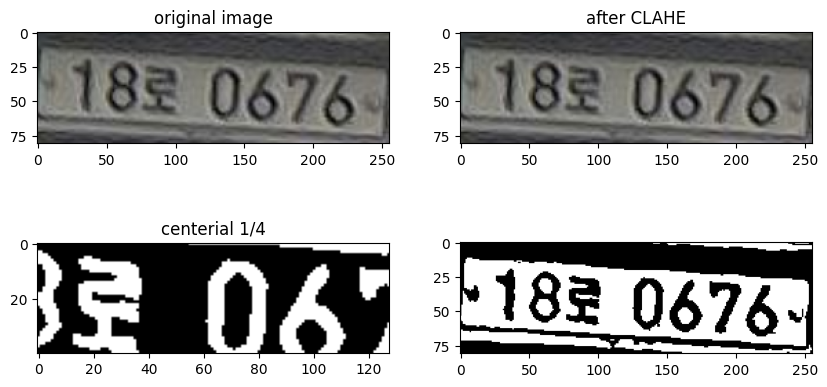

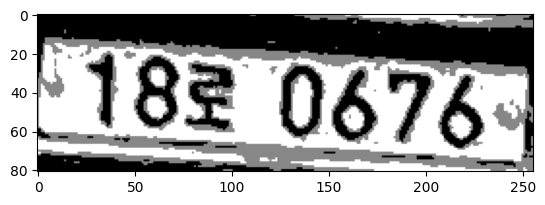

In [57]:
# show it
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.title('original image')
plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))
plt.subplot(222)
plt.title('after CLAHE')
plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))

segmented_image = minBatchKmeans(image, 2)

plt.subplot(223)
# get centerial 1/4 part of the image
h, w = segmented_image.shape[:2]
centerial = segmented_image[h // 4: h // 4 * 3, w // 4: w // 4 * 3]
plt.title('centerial 1/4')
plt.imshow(centerial, cmap='gray')

if np.sum(centerial == 0) > np.sum(centerial == 1):
    segmented_image = 1 - segmented_image
    # not image_raw
# else:
    image = 255 - image

# show the segmented image
plt.subplot(224)
plt.imshow(segmented_image, cmap='gray')
plt.show()

pick_0 = np.min(centerial)

# show kmeans k=3
k3 = kmeans(image_raw, 3)
plt.imshow(k3, cmap='gray')
plt.show()

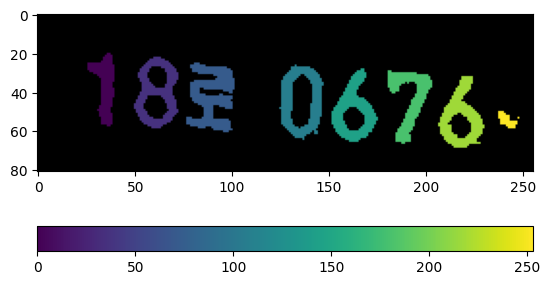

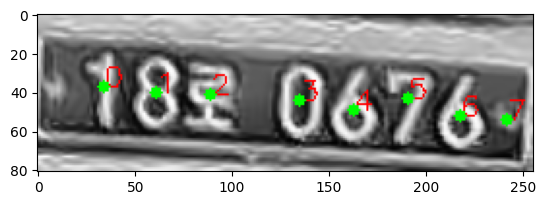

In [58]:
# normalize the colors  
def normalize_color(color, n=12):
    color = color / 255
    color = np.round(color * (n - 1))
    return color


def fit_bayesian_ridge(data, thr=1.0):
    # 转换为DataFrame
    df = pd.DataFrame(data, columns=['x', 'y', 'size'])
    # sort via x then y
    df = df.sort_values(['x', 'y'])
    # 特征和目标变量
    X = df[['x', 'y']]
    y = df['size']

    # 拟合模型
    model = BayesianRidge()
    model.fit(X, y)
    y_pred = model.predict(X)
    # 计算残差
    residuals = y - y_pred
    # 识别离群点
    threshold = thr * np.std(residuals)  # 设定残差的阈值
    # print the points without outliers
    tx = df[np.abs(residuals) <= threshold]
    return tx.values.tolist()


def hdbscan_cluster(image, target_value, min_cluster_size=100, max_cluster_size=2000):
    """
    Cluster points in an image using HDBSCAN and color the clusters.

    Parameters:
    - image: 2D numpy array of the image.
    - target_value: Pixel value to be clustered.
    - min_cluster_size: Minimum size of clusters to keep.
    - max_cluster_size: Maximum size of clusters to keep.

    Returns:
    - clustered_image: Image with clusters colored.
    - cluster_centers: Coordinates and sizes of cluster centers.
    """

    # list [x, y, color_idx, size]
    xys = []

    # Convert the image to a 2D array of points where pixel value is target_value
    points = np.argwhere(image == target_value)
    
    # Apply the HDBSCAN clustering
    hdbscan_model = HDBSCAN(cluster_selection_epsilon=1.5, min_samples=10).fit(points)
    labels = hdbscan_model.labels_

    # Get the number of clusters
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Calculate the cluster centers and filter based on size
    cluster_centers = np.zeros((num_clusters, 3), dtype=np.int32)

    for i in range(num_clusters):
        cluster_size = np.sum(labels == i)
        if cluster_size < min_cluster_size or cluster_size > max_cluster_size:
            continue
        cluster_centers[i, :2] = np.mean(points[labels == i], axis=0)
        cluster_centers[i, 2] = cluster_size

    # filter the cluster_centers which size is 0
    _len_centers_wo_0 = len(cluster_centers[cluster_centers[:, 2] != 0])

    # Sort the labels by the distance of the x and y coordinates to zero
    order = np.argsort(np.sum(cluster_centers[:, :2] ** 2, axis=1))
    cluster_centers = cluster_centers[order]

    # cluster_centers = fit_bayesian_ridge(cluster_centers, 0.5)
    # # to numpy array
    # cluster_centers = np.array(cluster_centers)

    # Create a random color map, ordered such as viridis
    colors = plt.cm.viridis(np.linspace(0, 1, _len_centers_wo_0))[:, :3] * 255
    colors = colors.astype(np.uint8)

    # Create a blank image
    clustered_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    color_idx = 0
    for i in range(len(cluster_centers)):
        # pass if center[2] is 0
        if cluster_centers[i, 2] == 0: continue
        # Get the mask of the current cluster
        mask = labels == order[i]
        # Apply the mask to the blank image
        clustered_image[points[mask][:, 0], points[mask][:, 1]] = colors[color_idx]
        # put all the points in the xys list
        for point in points[mask]:
            xys.append([point[0], point[1], color_idx, cluster_centers[i, 2]])

        color_idx += 1

    # print(xys)

    return clustered_image, cluster_centers, xys

# draw centers coordinates on the image
def draw_centers(image, centers):
    count = 0
    for i in range(len(centers)):
        # draw text
        x, y, s = centers[i].astype(int)
        if s == 0: continue
        x = int(np.clip(x, 0, image.shape[0] - 1))
        y = int(np.clip(y, 0, image.shape[1] - 1))
        cv2.putText(image, str(count), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.circle(image, (y, x), 3, (0, 255, 0), -1)
        count += 1
    return image


blank, centers, xys = hdbscan_cluster(segmented_image, pick_0, 50, 2500)

# Show the image
plt.imshow(blank)
plt.colorbar(orientation='horizontal')
plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = draw_centers(image, centers)
plt.imshow(image)
plt.show()

[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [ 37  34 275]
 [ 40  61 426]
 [ 41  89 523]
 [ 44 135 446]
 [ 49 163 416]
 [ 43 191 359]
 [ 52 218 406]
 [ 54 242  52]]


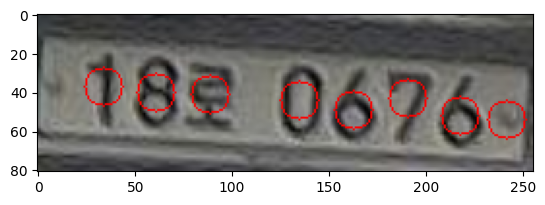

In [59]:
# draw gaussians on the image via given centers coordinates and sizes
def draw_gaussians(image, centers):
    for i in range(len(centers)):
        x, y, s = centers[i].astype(int)
        if s == 0: continue
        x = int(np.clip(x, 0, image.shape[0] - 1))
        y = int(np.clip(y, 0, image.shape[1] - 1))
        # draw a circle
        cv2.circle(image, (y, x), 10, (255, 0, 0), 1)
    return image


image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
print(centers)
image = draw_gaussians(image, centers)
plt.imshow(image)
plt.show()